In [27]:
#NEED TO IMPORT IN THE COLAB 3 DATASET: train.jsonl, dev.jsonl, test.jsonl AND IF YOU WANT, THE STATE

#Preapring Colab
!nvidia-smi -L 
import json
from google.colab import drive
import gensim 
import gensim.downloader as api
import os
import re
import torch.nn.functional as F

#Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

#Others
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU 0: Tesla T4 (UUID: GPU-b737be86-3798-cffe-c017-c77bbca845f5)


In [28]:
class Dataset():
  def __init__(self,w2v):
    self.w2v=w2v

#CREATE THE VOCABULARIES
  def vocable(self,data):
    vocab = {'PAD':0 , 'UNK':1}
    labels = {'O':0 , 'B-SCENARIO': 1  , 'B-SENTIMENT': 2, 'B-CHANGE':3, 'B-ACTION': 4, 'B-POSSESSION': 5 ,'I-SCENARIO': 6 , 'I-SENTIMENT': 7, 'I-CHANGE': 8, 'I-ACTION': 9,'I-POSSESSION' :10 }
    for i in range(0,len(data)):
      for j in data[i]['tokens']:
        if(j not in vocab):
            if j in w2v:
              vocab[j] = w2v.key_to_index[j]
    vocab_len = len(vocab)
    with open("vocab.json", "w") as outfile:
      json.dump(vocab, outfile)
    return vocab,labels,vocab_len

#READ THE FILE
  def datat(self,input):
    data = []
    with open(input, 'r') as json_file:
      json_list = list(json_file)
    for json_str in json_list:
      result = json.loads(json_str)
      data.append(result)
    
    return data

#BUILD 2 LISTS OF IDX FOR LABELS AND TOKENS FOR TRAINING 
  def lists(self,input):
    data=self.datat(input)
    vocab,labels,vocab_len = self.vocable(data)
    tokens_idx = []
    labels_idx = []
    for i in range(0,len(data)):
      token = []
      label = []
      for j in range(0,len(data[i]['tokens'])):
          if(data[i]['tokens'][j] in vocab):
            label.append(labels[data[i]['labels'][j]])
            token.append(vocab[data[i]['tokens'][j]])
          else:
            token.append(1)
            label.append(0)
      tokens_idx.append(token)
      labels_idx.append(label)
    return tokens_idx,labels_idx

#BUILD 2 LISTS OF IDX FOR LABELS AND TOKENS FOR TESTING
  def val_lists(self,input,vocab):
    data=self.datat(input)
    tokens_idx = []
    labels_idx = []
    for i in range(0,len(data)):
      token = []
      label = []
      for j in range(0,len(data[i]['tokens'])):
          if(data[i]['tokens'][j] in vocab):
            label.append(labels_dic[data[i]['labels'][j]])
            token.append(vocab[data[i]['tokens'][j]])
          else:
            token.append(1)
            label.append(0)
      tokens_idx.append(token)
      labels_idx.append(label)
    return tokens_idx,labels_idx

#TRANSFORM LISTS IN TENSORS
  def encode_data(self,l1,l2):
    tensor_tokens = torch.tensor(l1, dtype=torch.long).to(device)
    tensor_labels = torch.tensor(l2,dtype=torch.long).to(device)
    return tensor_tokens,tensor_labels

In [29]:
#CEATE BILSTM
class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_layer, dropout,num_classes):
    super(BiLSTM, self).__init__()
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layer
    self.dropout = dropout

    self.embedding= nn.Embedding.from_pretrained(embeddings=torch.FloatTensor(w2v.vectors),padding_idx=0,freeze=True)
    self.emb_dropout = nn.Dropout(dropout)

    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=num_layer,
                            bidirectional= True,
                            dropout = dropout)

    self.c_dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(hidden_dim * 2, num_classes)
  
  def forward(self, x):
    embedding_drop = self.emb_dropout(self.embedding(x))
    lstm, _ = self.lstm(embedding_drop.view(len(x),1,-1))
    classi = self.classifier(self.c_dropout(lstm.view(len(x),-1)))
    softmax = F.log_softmax(classi,dim=1)
    return softmax

In [30]:
# TRAINING
class Trainer():
  def __init__(self,model,loss_function,optimizer):
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self,tokens_t, epochs):
    for epoch in range(epochs):
      model.train()
      epoch_loss = 0.0
      accuracy = 0.0  
      f1 = 0.0
      labels_t = []
      labels_p = []
      for i in range(len(tokens_t)):
        sentence = tokens_t[i]
        labels = labelsL_t[i]

        model.zero_grad()
        tensor_token_t,tensor_label_t = dataset.encode_data(sentence,labels)
        predicted = self.model(tensor_token_t)
        loss = self.loss_function(predicted,tensor_label_t)

        _,indices =torch.max(predicted,1)
        for j in indices.tolist():
          labels_p.append(j)
        for j in labelsL_t[i]:
          labels_t.append(j)
        epoch_loss += loss.item()
        accuracy += accuracy_score(tensor_label_t.cpu().detach().numpy(), indices.cpu().detach().numpy())
        f1 += f1_score(tensor_label_t.cpu().detach().numpy(), indices.cpu().detach().numpy(),average='macro')
        
        loss.backward()
        self.optimizer.step()
      
      print("TRAIN    Epoch: {}, Loss: {}, Accuracy: {}, F1: {}".format(epoch+1,epoch_loss/len(tokens_t),accuracy/len(tokens_t),f1/len(tokens_t)))
      #self.validate(tokens_d)
      labels_t=self.convert(labels_t)
      labels_p=self.convert(labels_p)
      cm = confusion_matrix(labels_t,  labels_p)
      disp = ConfusionMatrixDisplay.from_predictions(
                                              labels_t, 
                                              labels_p, 
                                              normalize='true',
                                              cmap=plt.cm.Blues
                                              ) 
      plt.xticks(rotation=90)
      fig = disp.figure_
      fig.set_figwidth(11)
      fig.set_figheight(10) 
      fig.suptitle('Confusion Matrix Train')
      torch.save(model.state_dict(),"State{}.pt".format(epoch+1))

  def validate(self,tokens_d):
    model.eval()
    f1 = 0.0
    accuracy = 0.0
    labels_t = []
    labels_p = []
    for i in range(len(tokens_d)):
      sentence = tokens_d[i]
      labels = labelsL_d[i]

      tensor_token_d,tensor_label_d = dataset.encode_data(sentence,labels)
      predicted = model(tensor_token_d)

      _,indices=torch.max(predicted,1)
      for j in indices.tolist():
        labels_p.append(j)
      for j in labelsL_d[i]:
        labels_t.append(j)
      f1 += f1_score(tensor_label_d.cpu().detach().numpy(), indices.cpu().detach().numpy(),average='macro')
      accuracy += accuracy_score(tensor_label_d.cpu().detach().numpy(), indices.cpu().detach().numpy())
    labels_t = self.convert(labels_t)
    labels_p = self.convert(labels_p)
    cm = confusion_matrix(labels_t,  labels_p)
    
    disp = ConfusionMatrixDisplay.from_predictions(
                                              labels_t, 
                                              labels_p, 
                                              normalize='true',
                                              cmap=plt.cm.Blues
                                              ) 
    plt.xticks(rotation=90)
    fig = disp.figure_
    fig.set_figwidth(11)
    fig.set_figheight(10) 
    fig.suptitle('Confusion Matrix Dev')
    
    print("DEV      Accuracy: {}, F1: {}".format(accuracy/len(tokens_d),f1/len(tokens_d)))

  def test(self,tokens_test):
    model.eval()
    f1 = 0.0
    accuracy = 0.0
    labels_t = []
    labels_p = []
    for i in range(len(tokens_test)):
      sentence = tokens_test[i]
      labels = labelsL_test[i]

      tensor_token_test,tensor_label_test = dataset.encode_data(sentence,labels)
      predicted = model(tensor_token_test)

      _,indices = torch.max(predicted,1)
      for j in indices.tolist():
        labels_p.append(j)
      for j in labelsL_test[i]:
        labels_t.append(j)
      f1 += f1_score(tensor_label_test.cpu().detach().numpy(), indices.cpu().detach().numpy(),average='macro')
      accuracy += accuracy_score(tensor_label_test.cpu().detach().numpy(), indices.cpu().detach().numpy())
    labels_t = self.convert(labels_t)
    labels_p = self.convert(labels_p)
    cm = confusion_matrix(labels_t,  labels_p)
    
    disp = ConfusionMatrixDisplay.from_predictions(
                                              labels_t, 
                                              labels_p,  
                                              normalize='true',
                                              cmap=plt.cm.Blues
                                              ) 
    plt.xticks(rotation=90)
    fig = disp.figure_
    fig.set_figwidth(11)
    fig.set_figheight(10) 
    fig.suptitle('Confusion Matrix Test')
    
    print("TEST     Accuracy: {}, F1: {}\n".format(accuracy/len(tokens_test),f1/len(tokens_test)))

  def convert(self,list):
    labels = []
    for i in list:
      for key, value in labels_dic.items():
        if i == value:
          labels.append(key)
    return labels
    

In [5]:
#IMPORT  EMBEDDING
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [31]:
# SET HYPERPARAMETERS
embedding_dim = 300
hidden_dim = 350
num_layer = 2
dropout = 0.25
lr = 0.1
num_classes = 11

#INIZIALIZE THE DATASET 
dataset = Dataset(w2v)

#READ THE FILE
data_t = dataset.datat('train.jsonl')

#CREATE THE VOCAB
vocab,labels_dic,vocab_len = dataset.vocable(data_t)

#TRANSFORM THE SENTENCES OF STRING IN LIST OF NUMBERS
tokens_t,labelsL_t = dataset.lists('train.jsonl')
tokens_d,labelsL_d = dataset.val_lists('dev.jsonl',vocab)
tokens_test,labelsL_test = dataset.val_lists('test.jsonl',vocab)

In [32]:
#DEFINING THE MODEL
model=BiLSTM(embedding_dim, hidden_dim, num_layer, dropout,num_classes).to(device)
#UNCOMMENT IF YOU WANT LOAD A STATE
#model.load_state_dict(torch.load('state603forsemeglio.pt', map_location=torch.device('cpu')))
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.NLLLoss()
model.train()

BiLSTM(
  (embedding): Embedding(3000000, 300, padding_idx=0)
  (emb_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 350, num_layers=2, dropout=0.25, bidirectional=True)
  (c_dropout): Dropout(p=0.25, inplace=False)
  (classifier): Linear(in_features=700, out_features=11, bias=True)
)

In [33]:
#SET TRAINER
trainer = Trainer(model,criterion,optimizer)

TRAIN    Epoch: 1, Loss: 0.29024039791218237, Accuracy: 0.9138089244621921, F1: 0.5227246466432838
DEV      Accuracy: 0.9300664084191841, F1: 0.6176454911219972
TEST     Accuracy: 0.9302512206911513, F1: 0.6198469571450809



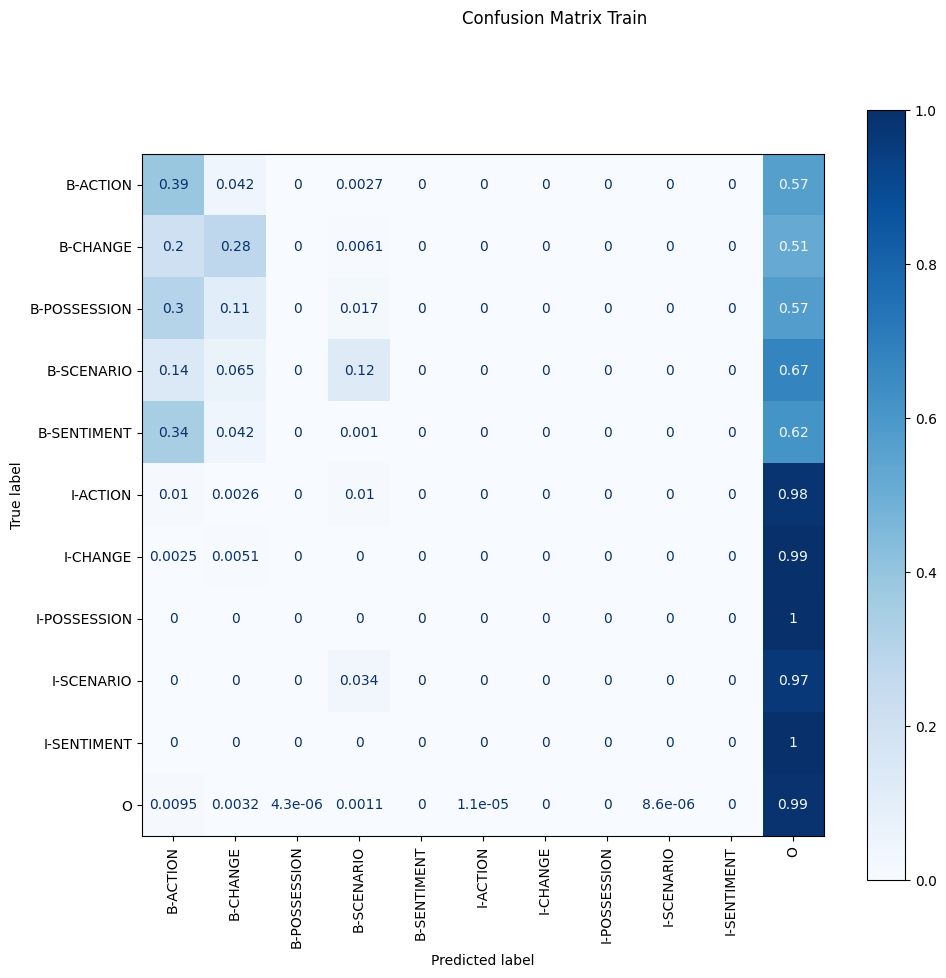

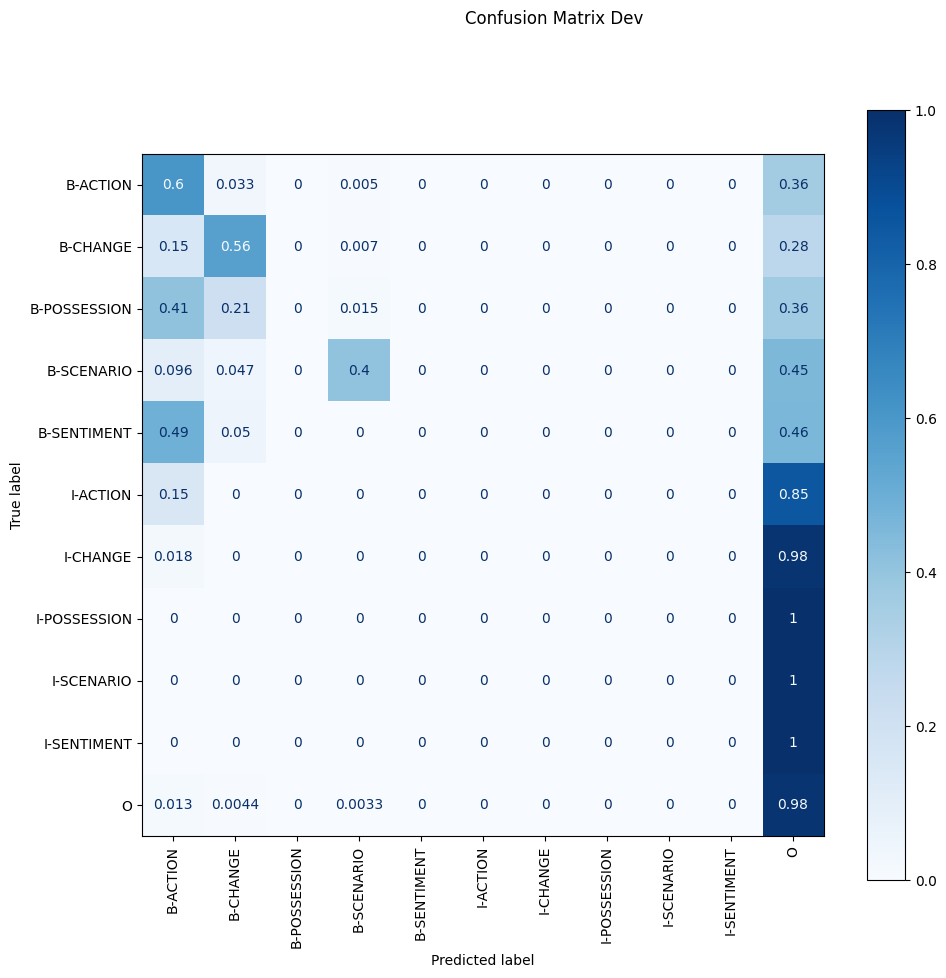

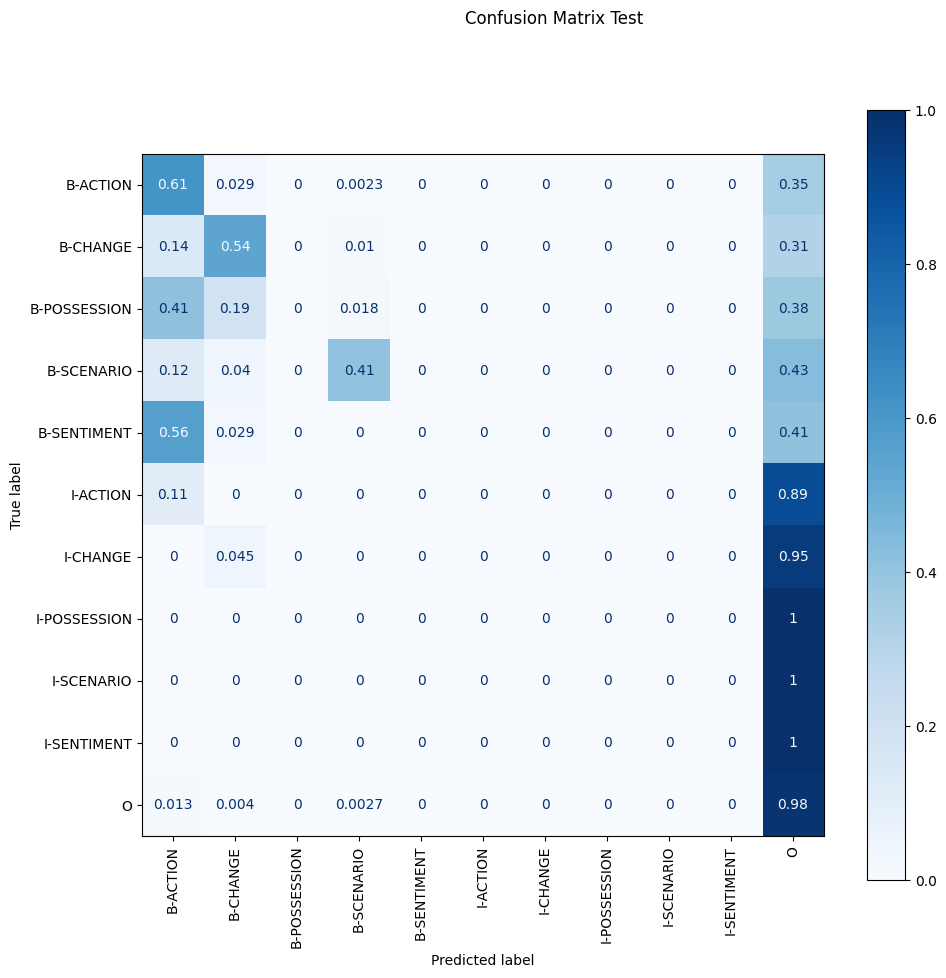

In [34]:
#TRAIN, VALIDATE AND TEST
trainer.train(tokens_t,1)
trainer.validate(tokens_d)
trainer.test(tokens_test)